In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv('FinalApartments_data.csv')
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (99105, 23)
           id                category                            title  \
0  5668640009  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  5668639818  housing/rent/apartment      Three BR 146 Lochview Drive   
2  5668639686  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  5668639659  housing/rent/apartment            Two BR 209 Aegean Way   
4  5668639374  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body      amenities  \
0  This unit is located at 507 & 509 Esplanade, R...  Not Specified   
1  This unit is located at 146 Lochview Drive, Ne...  Not Specified   
2  This unit is located at 3101 Morningside Drive...  Not Specified   
3  This unit is located at 209 Aegean Way, Vacavi...  Not Specified   
4  This unit is located at 4805 Marquette NE, Alb...  Not Specified   

   bathrooms  bedrooms currency fee  has_photo  ... price_type  square_feet  \
0        1.0         1

In [3]:
# Explore the data
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
                 id     bathrooms      bedrooms         price   square_feet  \
count  9.910500e+04  99105.000000  99105.000000  99105.000000  99105.000000   
mean   5.358114e+09      1.444211      1.727996   1504.398446    955.996045   
std    1.846979e+08      0.540922      0.745009    699.620263    387.732138   
min    5.121046e+09      1.000000      0.000000    100.000000    101.000000   
25%    5.197948e+09      1.000000      1.000000   1012.000000    729.000000   
50%    5.508672e+09      1.000000      2.000000   1350.000000    900.000000   
75%    5.509006e+09      2.000000      2.000000   1795.000000   1115.000000   
max    5.669439e+09      4.000000      5.000000   4250.000000  40000.000000   

           latitude     longitude          time  
count  99105.000000  99105.000000  9.910500e+04  
mean      36.935306    -91.531186  1.559652e+09  
std        4.573403     15.759434  1.105025e+07  
min       24.396308   -125.000000  1.544174e+09  
25%       33.7436

In [4]:
# Check data types
print("\nData Types:")
print(data.dtypes)


Data Types:
id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms           int64
currency          object
fee               object
has_photo         object
pets_allowed      object
price            float64
price_display     object
price_type        object
square_feet        int64
cityname          object
state             object
latitude         float64
longitude        float64
source            object
time               int64
state_name        object
datetime          object
dtype: object


In [5]:
# Check missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
id               0
category         0
title            0
body             0
amenities        0
bathrooms        0
bedrooms         0
currency         0
fee              0
has_photo        0
pets_allowed     0
price            0
price_display    0
price_type       0
square_feet      0
cityname         0
state            0
latitude         0
longitude        0
source           0
time             0
state_name       0
datetime         0
dtype: int64


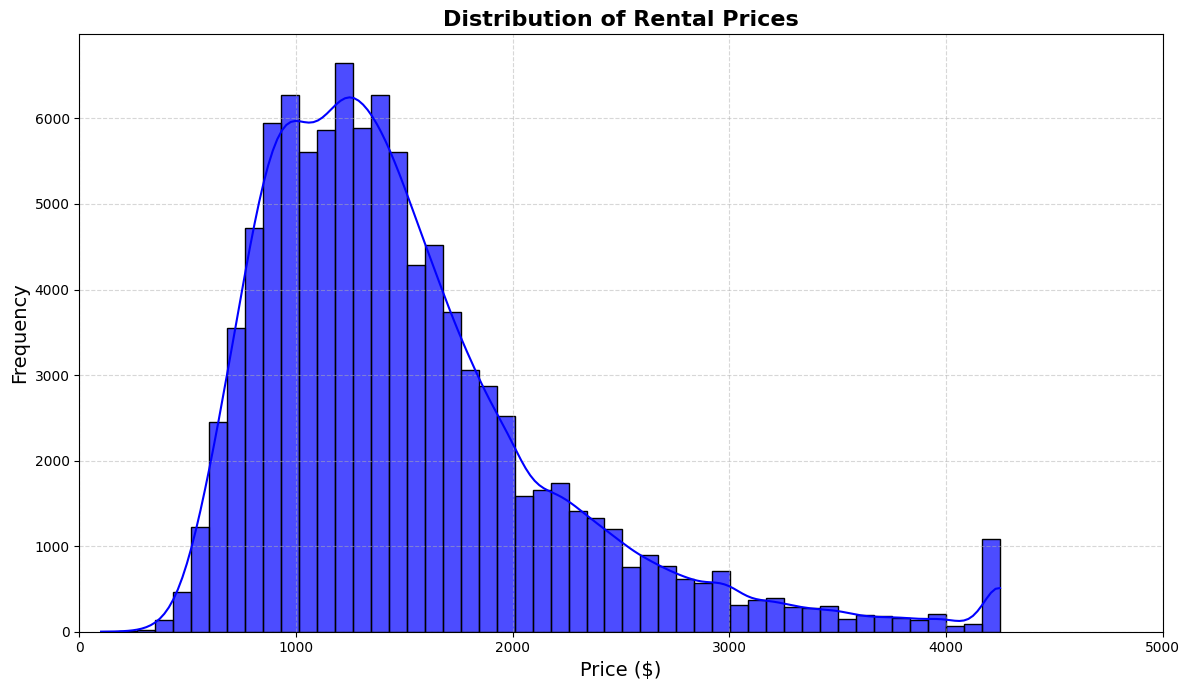

In [6]:
plt.figure(figsize=(12, 7))
sns.histplot(data['price'], bins=50, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Rental Prices', fontsize=16, fontweight='bold')
plt.xlabel('Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, 5000)
plt.tight_layout()
plt.savefig('project_visualization/Distribution_of_Rental_Prices.png')
plt.show()

In [7]:
# Data Preprocessing
# categorizing price into (High, Low, and Mediun)
def categorize_price(price, data):
    q1 = data['price'].quantile(0.33)
    q2 = data['price'].quantile(0.67)
    if price <= q1:
        return 'Low'
    elif price <= q2:
        return 'Medium'
    else:
        return 'High'

data['price_category'] = data['price'].apply(lambda x: categorize_price(x, data))

# Displaying distribution of price categories
price_distribution = data['price_category'].value_counts()
print("\nPrice Category Distribution:")
print(price_distribution)
print(f"Low: {price_distribution['Low']/len(data)*100:.2f}% | "
      f"Medium: {price_distribution['Medium']/len(data)*100:.2f}% | "
      f"High: {price_distribution['High']/len(data)*100:.2f}%")


Price Category Distribution:
price_category
Medium    33602
Low       32804
High      32699
Name: count, dtype: int64
Low: 33.10% | Medium: 33.91% | High: 32.99%


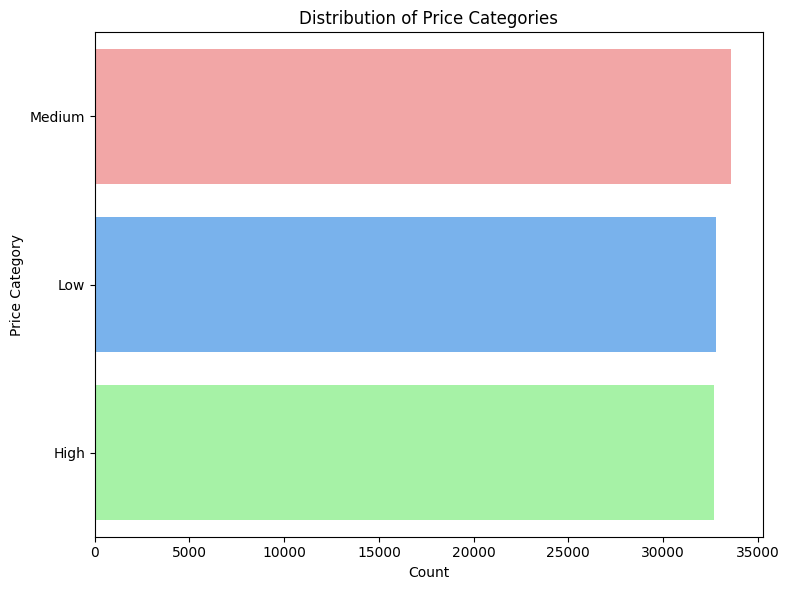

In [8]:
# Visualize price categories
plt.figure(figsize=(8, 6))
sns.countplot(y='price_category', data=data, order=data['price_category'].value_counts().index, palette=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Distribution of Price Categories')
plt.xlabel('Count')
plt.ylabel('Price Category')
plt.tight_layout()
plt.savefig('project_visualization/price_category_distribution.png')
plt.show()

In [ ]:
# Feature Engineering
print("\nPerforming feature engineering...")

# Creating new features from existing one's
# Bedrooms to bathrooms ratio
data['bed_bath_ratio'] = data.apply(
    lambda row: row['bedrooms'] / max(row['bathrooms'], 0.5), axis=1
)

# square feet per bedroom
data['sqft_per_bedroom'] = data.apply(
    lambda row: row['square_feet'] / max(row['bedrooms'], 1), axis=1
)

# Process amenities if available
if 'amenities' in data.columns:
    print("Processing amenities data...")
    
    common_amenities = ['Parking', 'AC', 'Dishwasher', 'Laundry', 'Pool', 'Gym']
    
    for amenity in common_amenities:
        data[f'has_{amenity.lower()}'] = data['amenities'].str.contains(amenity, case=False, na=False).astype(int)
    data['amenities_count'] = data['amenities'].apply(
        lambda x: len(str(x).split(',')) if pd.notna(x) else 0
    )

# Adding temporal features if available
if 'datetime' in data.columns:
    print("Adding temporal features...")
    data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
    data['month'] = data['datetime'].dt.month.fillna(1).astype(int)
    data['day_of_week'] = data['datetime'].dt.dayofweek.fillna(0).astype(int)
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Select relevant numerical and categorical features
numerical_features = [
    'bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude',
    'bed_bath_ratio', 'sqft_per_bedroom'
]

if 'has_parking' in data.columns:
    numerical_features.extend(['has_parking', 'has_ac', 'has_dishwasher', 'has_laundry', 'has_pool', 'has_gym', 'amenities_count'])

if 'month' in data.columns:
    numerical_features.extend(['month', 'is_weekend'])

categorical_features = ['state', 'pets_allowed', 'price_type']

numerical_features = [f for f in numerical_features if f in data.columns]
categorical_features = [f for f in categorical_features if f in data.columns]

print("Applying one-hot encoding to categorical features...")
encoded_features = pd.get_dummies(data[categorical_features], drop_first=False)

X_numerical = data[numerical_features]
X = pd.concat([X_numerical, encoded_features], axis=1)
y = data['price_category']

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Performing feature engineering...
Processing amenities data...
Adding temporal features...
Applying one-hot encoding to categorical features...

Numerical features: ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude', 'bed_bath_ratio', 'sqft_per_bedroom', 'has_parking', 'has_ac', 'has_dishwasher', 'has_laundry', 'has_pool', 'has_gym', 'amenities_count', 'month', 'is_weekend']
Categorical features: ['state', 'pets_allowed', 'price_type']


## Naive Bayes implementation for rental price prediction

In [ ]:
# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set size: {len(X_train)}, Test set size: {len(X_test)}")

print("\nCreating Naive Bayes model...")

numerical_cols = [col for col in X_train.columns if col in numerical_features]
encoded_cols = [col for col in X_train.columns if col not in numerical_features]

X_train_num = X_train[numerical_cols].copy()
X_test_num = X_test[numerical_cols].copy()

imputer = SimpleImputer(strategy='median')
X_train_num = imputer.fit_transform(X_train_num)
X_test_num = imputer.transform(X_test_num)

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test.index)

X_train_cat = X_train[encoded_cols]
X_test_cat = X_test[encoded_cols]

X_train_processed = pd.concat([X_train_num_df, X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat], axis=1)

print("\nTuning hyperparameters for Naive Bayes...")
param_grid = {
    'var_smoothing': np.logspace(-9, -1, 9)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Training set size: 79284, Test set size: 19821

Creating Naive Bayes model...

Tuning hyperparameters for Naive Bayes...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'var_smoothing': np.float64(0.1)}
Best cross-validation score: 0.6128


In [ ]:
# Train final model with best parameters
print("\nTraining and evaluating Naive Bayes...")
final_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
final_model.fit(X_train_processed, y_train)

y_train_pred = final_model.predict(X_train_processed)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nNaive Bayes Training Accuracy: {train_accuracy:.4f}")

y_pred = final_model.predict(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nNaive Bayes Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(conf_matrix)


Training and evaluating Naive Bayes...

Naive Bayes Training Accuracy: 0.6146

Naive Bayes Test Accuracy: 0.6119

Classification Report:
              precision    recall  f1-score   support

        High       0.65      0.67      0.66      6540
         Low       0.66      0.68      0.67      6561
      Medium       0.51      0.49      0.50      6720

    accuracy                           0.61     19821
   macro avg       0.61      0.61      0.61     19821
weighted avg       0.61      0.61      0.61     19821


Confusion Matrix:
[[4380  580 1580]
 [ 557 4489 1515]
 [1755 1705 3260]]



Generating visualizations...
Saved confusion matrix visualization to 'naive_bayes_confusion_matrix.png'


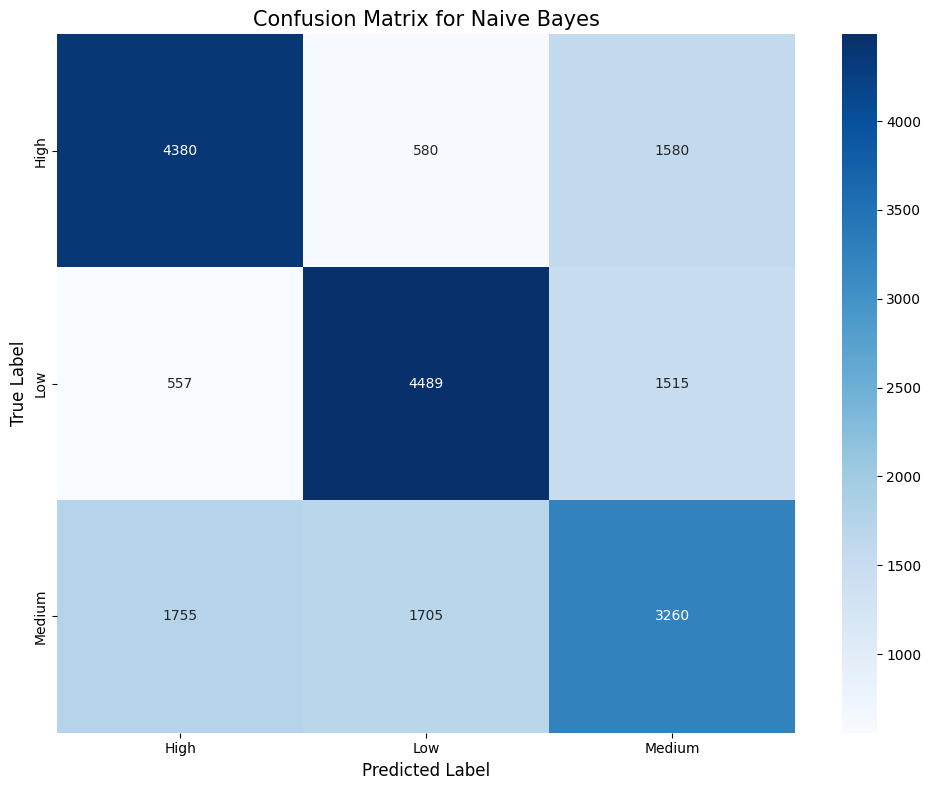

In [57]:
print("\nGenerating visualizations...")
plt.figure(figsize=(10, 8))
class_labels = final_model.classes_ if hasattr(final_model, 'classes_') else np.unique(y_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Naive Bayes', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('project_visualization/naive_bayes_confusion_matrix.png')
print("Saved confusion matrix visualization to 'naive_bayes_confusion_matrix.png'")


Generating ROC curves...
Saved ROC curves to 'naive_bayes_roc_curves.png'

Model training and evaluation complete!


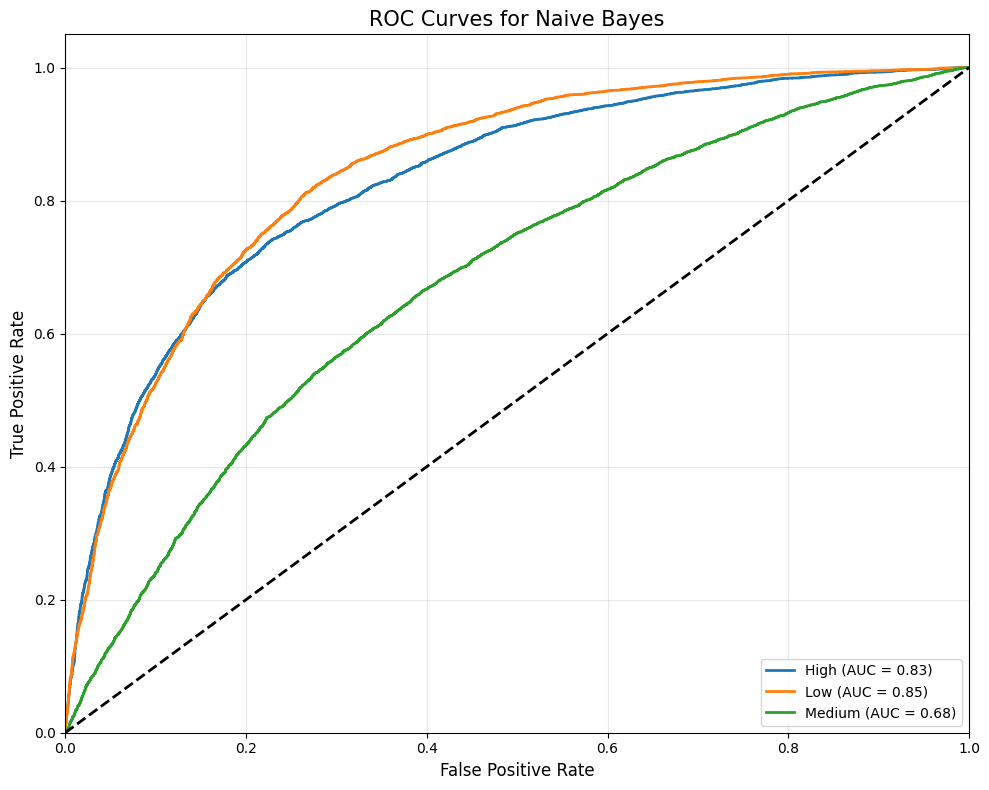

In [ ]:
# ROC curve for multi-class (one vs rest)
try:
    from sklearn.metrics import roc_curve, auc
    print("\nGenerating ROC curves...")
    
    plt.figure(figsize=(10, 8))
    y_proba = final_model.predict_proba(X_test_processed)
    y_test_binarized = pd.get_dummies(y_test).values
    
    class_labels = final_model.classes_
    
    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Naive Bayes', fontsize=15)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('project_visualization/naive_bayes_roc_curves.png')
    print("Saved ROC curves to 'naive_bayes_roc_curves.png'")
except Exception as e:
    print(f"Couldn't generate ROC curves: {e}")

print("\nModel training and evaluation complete!")


Analyzing feature importance for Naive Bayes...
Saved feature importance visualization to 'naive_bayes_feature_importance.png'

Naive Bayes model training and evaluation complete!


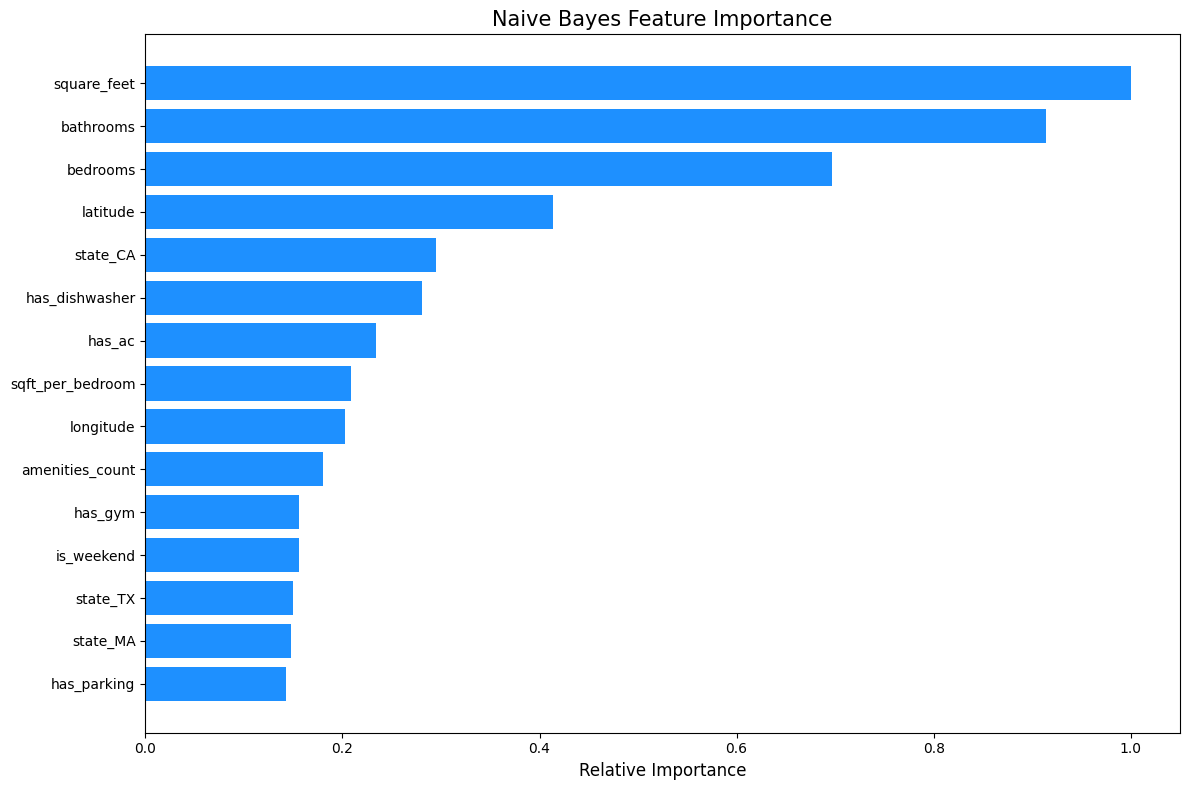

In [ ]:
# Feature importance analysis
print("\nAnalyzing feature importance for Naive Bayes...")
try:
    feature_names = X_train_processed.columns.tolist()
    importance = np.zeros(len(feature_names))
    
    for i in range(len(final_model.classes_)):
        for j in range(i+1, len(final_model.classes_)):
            importance += np.abs(final_model.theta_[i] - final_model.theta_[j])
    
    importance = importance / np.max(importance)
    indices = np.argsort(importance)[-15:]
    
    plt.figure(figsize=(12, 8))
    plt.title('Naive Bayes Feature Importance', fontsize=15)
    plt.barh(range(len(indices)), importance[indices], color='dodgerblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance', fontsize=12)
    plt.tight_layout()
    plt.savefig('project_visualization/naive_bayes_feature_importance.png')
    print("Saved feature importance visualization to 'naive_bayes_feature_importance.png'")
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")

print("\nNaive Bayes model training and evaluation complete!")

## AdaBoost Implementation for Rental Price Prediction

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

print("\nCreating AdaBoost model...")

numerical_cols = [col for col in X_train.columns if col in numerical_features]
encoded_cols = [col for col in X_train.columns if col not in numerical_features]

X_train_num = X_train[numerical_cols].copy()
X_test_num = X_test[numerical_cols].copy()

imputer = SimpleImputer(strategy='median')
X_train_num = imputer.fit_transform(X_train_num)
X_test_num = imputer.transform(X_test_num)

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test.index)

X_train_cat = X_train[encoded_cols]
X_test_cat = X_test[encoded_cols]

X_train_processed = pd.concat([X_train_num_df, X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat], axis=1)

base_estimator = DecisionTreeClassifier(max_depth=1)

print("\nTuning hyperparameters for AdaBoost...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    AdaBoostClassifier(estimator=base_estimator, random_state=42),
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_processed, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Training set size: 79284, Test set size: 19821

Creating AdaBoost model...

Tuning hyperparameters for AdaBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 1.0, 'n_estimators': 200}
Best cross-validation score: 0.6494


In [ ]:
# Train and evaluate model
final_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)
final_model.fit(X_train_processed, y_train)

y_train_pred = final_model.predict(X_train_processed)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nAdaBoost Training Accuracy: {train_accuracy:.4f}")

y_pred = final_model.predict(X_test_processed)
y_proba = final_model.predict_proba(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nAdaBoost Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(conf_matrix)


AdaBoost Training Accuracy: 0.6483

AdaBoost Test Accuracy: 0.6488

Classification Report:
              precision    recall  f1-score   support

        High       0.73      0.70      0.72      6540
         Low       0.71      0.67      0.69      6561
      Medium       0.52      0.57      0.55      6720

    accuracy                           0.65     19821
   macro avg       0.66      0.65      0.65     19821
weighted avg       0.66      0.65      0.65     19821


Confusion Matrix:
[[4583  314 1643]
 [ 274 4424 1863]
 [1405 1462 3853]]



Generating visualizations...
Saved confusion matrix visualization to 'adaboost_confusion_matrix.png'


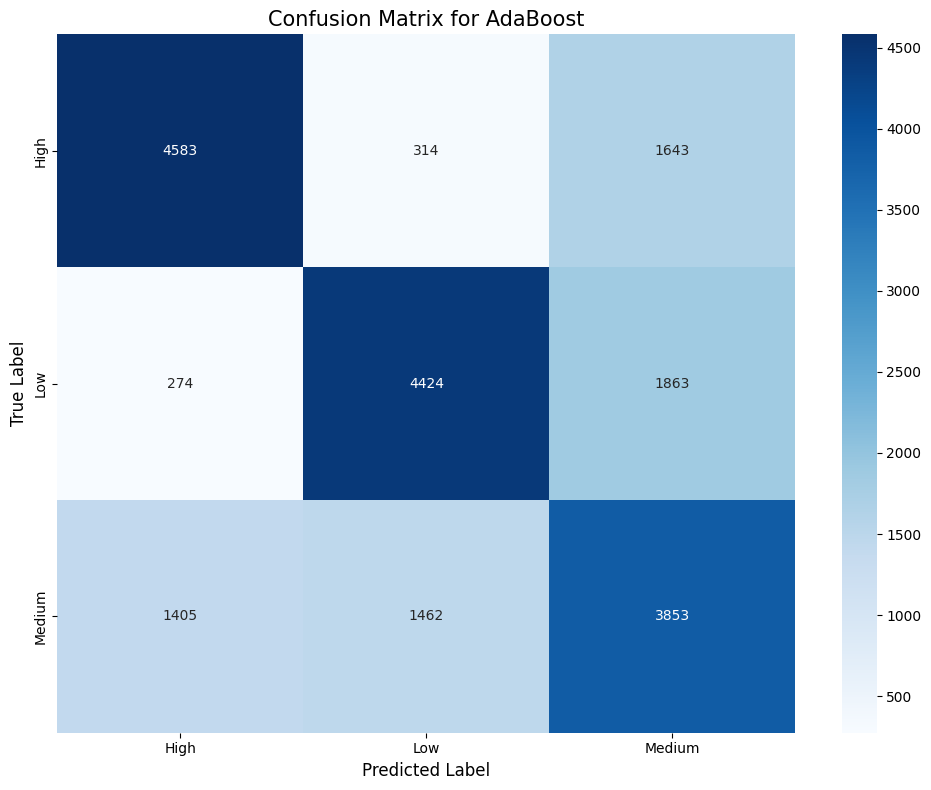

In [62]:
# Visualize confusion matrix
print("\nGenerating visualizations...")
plt.figure(figsize=(10, 8))
class_labels = final_model.classes_ if hasattr(final_model, 'classes_') else np.unique(y_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for AdaBoost', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('project_visualization/adaboost_confusion_matrix.png')
print("Saved confusion matrix visualization to 'adaboost_confusion_matrix.png'")


Generating ROC curves...
Saved ROC curves to 'adaboost_roc_curves.png'


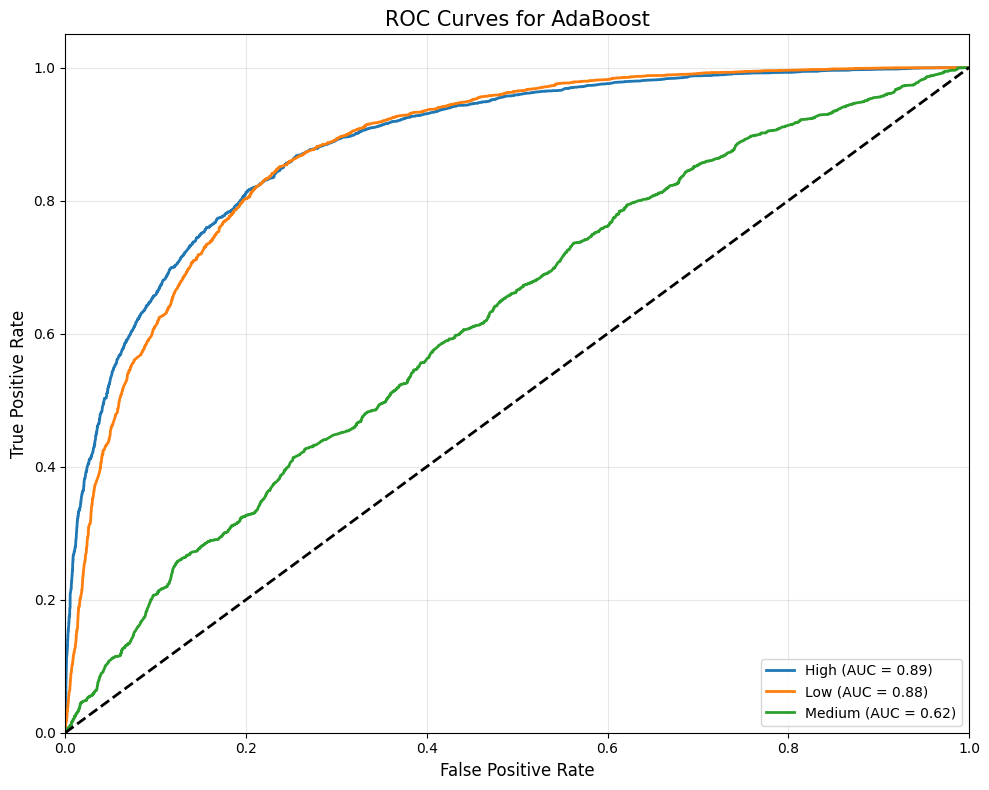

In [63]:
# ROC curve for multi-class (one vs rest)
try:
    from sklearn.metrics import roc_curve, auc
    print("\nGenerating ROC curves...")
    
    plt.figure(figsize=(10, 8))
    y_test_binarized = pd.get_dummies(y_test).values
    
    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for AdaBoost', fontsize=15)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('project_visualization/adaboost_roc_curves.png')
    print("Saved ROC curves to 'adaboost_roc_curves.png'")
except Exception as e:
    print(f"Couldn't generate ROC curves: {e}")

Saved feature importance visualization to 'adaboost_feature_importance.png'

AdaBoost model training and evaluation complete!


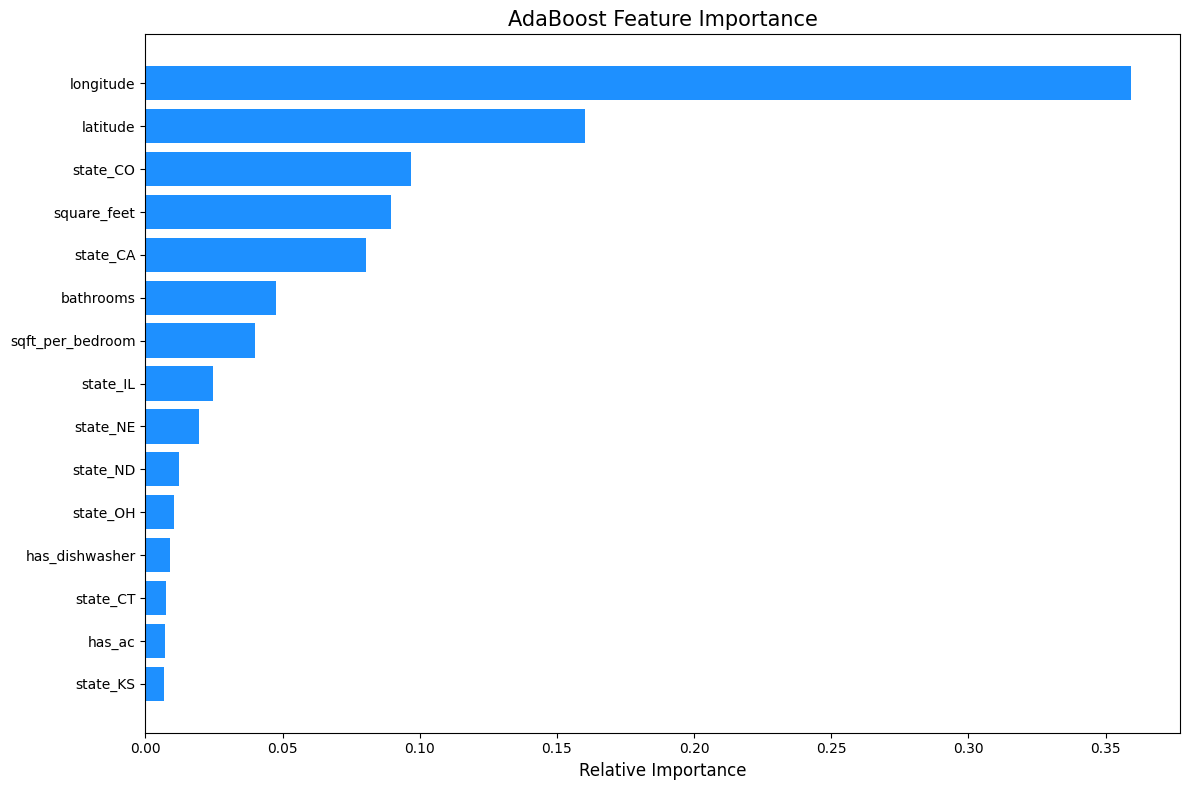

In [64]:
# Feature importance
try:
    # Get feature importance from AdaBoost
    feature_names = X_train_processed.columns
    feature_importance = final_model.feature_importances_
    
    # Sort feature importance
    indices = np.argsort(feature_importance)[-15:]  # Top 15 features
    
    plt.figure(figsize=(12, 8))
    plt.title('AdaBoost Feature Importance', fontsize=15)
    plt.barh(range(len(indices)), feature_importance[indices], color='dodgerblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance', fontsize=12)
    plt.tight_layout()
    plt.savefig('project_visualization/adaboost_feature_importance.png')
    print("Saved feature importance visualization to 'adaboost_feature_importance.png'")
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")

print("\nAdaBoost model training and evaluation complete!")